# Figure 4
<img src="files/img/fig4.png",width=400>
Sharp beta oscillations yield phase-locked high gamma amplitude. A, Sharpness ratio is highly correlated with estimated PAC across all subjects before DBS. B–F, Illustration of the
relationship between extrema sharpness and phase-locked high gamma amplitude for an example PD patient before DBS. B, Extrema sharpness is positively correlated with the high gamma
amplitude at the extrema. C, High gamma amplitude is locked to the peak of beta oscillations specifically for the sharpest beta oscillations. Beta cycles were split into five groups based on the peak
sharpness. Line color varies from the least sharp beta cycles (light gray) to the sharpest beta cycles (black).D, The distribution of highgammaamplitude as a function of beta phase is uniform for beta
cycles with low sharpness (light gray) and nonuniform for sharp beta cycles. E, Spectrogram of a 400 ms period of raw voltage recording exhibiting beta oscillations. The sharpest beta oscillations
(peaks 2, 3, 4, and 6) have increased amplitude in the highgammafrequency range compared with the cycles with lower sharpness (peaks 1 and 5). F, Event-related average of raw voltage triggered
at the peaks of high gamma oscillations (with the top 10% of amplitude).

**Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

In [2]:
import util

**Load data**

In [3]:
ecog = util.loadPD()
Fs, t, S, Sdy, flo, fhi = util.loadmeta()

**sharpness calculations**

In [4]:
widthS = 5 # hyperparameter for calculating sharpness

pks, trs, pksharp, trsharp, esrs, \
peaktotrough, risteep, desteep, rdsrs, \
risetodecay = util.measure_shape(ecog, widthS=widthS)

**Calculate PAC**

In [5]:
pac = util.measure_pac(ecog, flo, fhi)

# A
### Sharpness ratio and PAC highly correlated across subjects

(0.9440377033738041, 1.3889835638086092e-11)


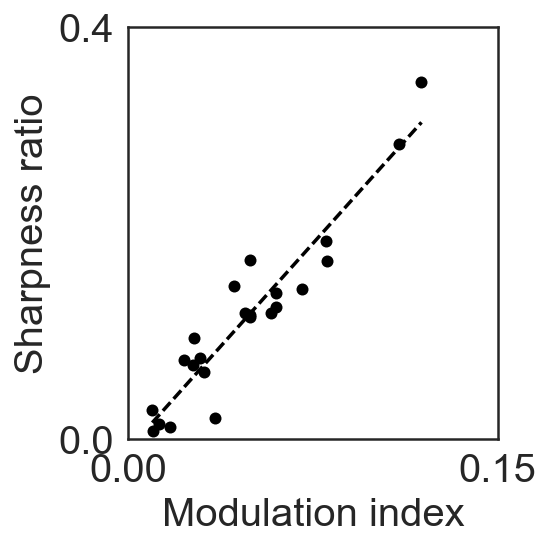

In [6]:
from plt import scatt_corr
scatt_corr(pac['B'], esrs['B'], xlabel='Modulation index',ylabel='Sharpness ratio',
          xlim = (0,0.15),ylim=(0,0.4),figsize=(4,4),showline=True)
plt.xticks(size=20)
plt.yticks(size=20)
plt.tight_layout()

print(sp.stats.pearsonr(pac['B'], esrs['B']))

In [7]:
# Repeat for during DBS
print(sp.stats.pearsonr(pac['D'], esrs['D']))

(0.88622061251570694, 1.8428143087983434e-08)


# B
Peak sharpness is highly correlated to high gamma amplitude

In [8]:
# Calculate high gamma amplitude time series for one subject
import pac
group = 'B'
subj = 0
x = ecog[group][subj]
hg = pac.firf(x, fhi, fs=Fs, Ntaps=240,rmvedge=False)
hga = np.abs(sp.signal.hilbert(hg))

# Calculate high gamma amplitude at each peak
hgapk = hga[pks[group][subj]]

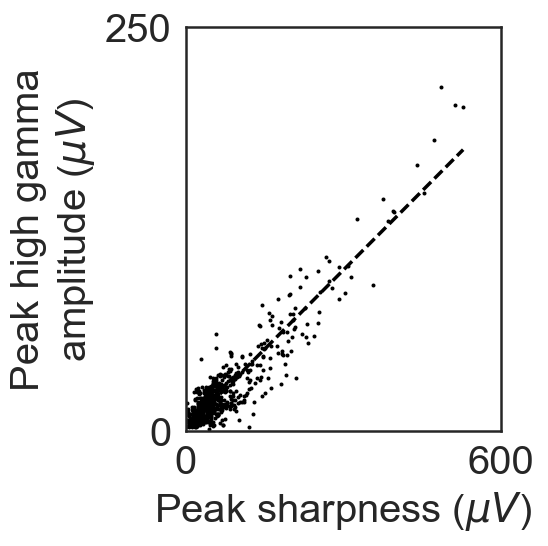

In [9]:
# Plot correlation
scatt_corr(pksharp[group][subj],hgapk,
           xlabel='Peak sharpness ($\mu V$)',ylabel='Peak high gamma\namplitude ($\mu V$)',
          figsize=(4,4),ms=4,xlim=(0,600),ylim=(0,250),showline=True)
plt.xticks(size=20)
plt.yticks(size=20)
plt.tight_layout()

# C
### High gamma is time-locked to for sharp and not flat peaks

In [10]:
# Calculate high gamma amplitude time series for one subject
group = 'B'
subj = 2
x = ecog[group][subj]
hg = pac.firf(x, fhi, fs=Fs, Ntaps=240,rmvedge=False)
hga = np.abs(sp.signal.hilbert(hg))

# Calculate high gamma amplitude at each peak
hgapk = hga[pks[group][subj]]

# Identify peak arrays of interest
xpks = pks[group][subj]
xpkssharp = pksharp[group][subj]

In [11]:
# Define time interval for analysis
tplotmin = -.025
tplotmax = .025
splotmin = int(tplotmin*Fs)
splotmax = int(tplotmax*Fs)
tplot = np.arange(tplotmin,tplotmax,1/float(Fs))

# Remove peaks close to boundary
xpks = xpks[xpks>tplotmax*Fs]
xpks = xpks[len(x)-xpks>tplotmax*Fs]

xpkssharp = xpkssharp[xpks>tplotmax*Fs]
xpkssharp = xpkssharp[len(x)-xpks>tplotmax*Fs]

In [12]:
# Split cycles into 5 groups
Nsharpg = 5

sharpThresh = np.zeros(Nsharpg+1)
for n in range(Nsharpg):
    sharpThresh[n] = np.percentile(xpkssharp,100*n/float(Nsharpg))
sharpThresh[0] = sharpThresh[0]-1
sharpThresh[-1] = np.percentile(xpkssharp,100)

pkidxg = np.zeros(Nsharpg,dtype=object)
pksharpg = np.zeros(Nsharpg,dtype=object)
for n in range(Nsharpg):
    pkidxg[n] = xpks[np.logical_and(xpkssharp>sharpThresh[n],xpkssharp<=sharpThresh[n+1])]
    pksharpg[n] = xpkssharp[np.logical_and(xpkssharp>sharpThresh[n],xpkssharp<=sharpThresh[n+1])]

In [13]:
# Time lock the high gamma power to the peak of each group
hg_timelockpeak = np.zeros((Nsharpg,len(tplot)))
for n in range(Nsharpg):
    P = len(pkidxg[n])
    for p in range(P):
        newtimeseries = hga[pkidxg[n][p]+splotmin:pkidxg[n][p]+splotmax]
        hg_timelockpeak[n] = hg_timelockpeak[n] + newtimeseries/float(P)

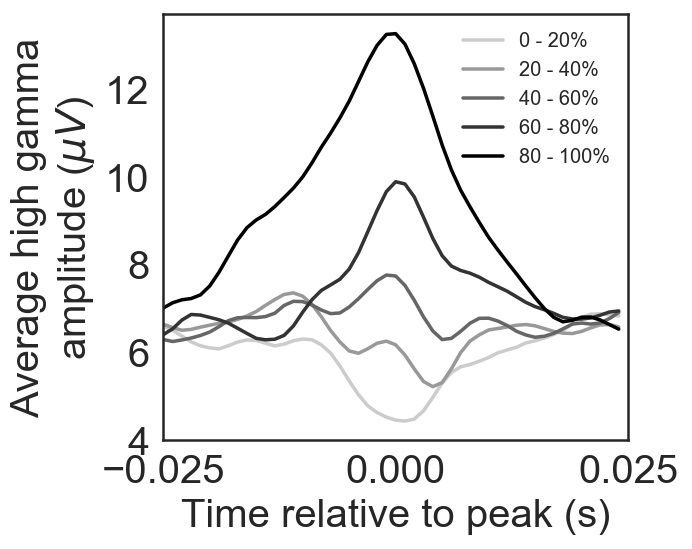

In [14]:
# Calculate average high gamma amp triggered at peak of each sharpness
plt.figure(figsize=(5,4))
for n in range(Nsharpg):
    plt.plot(tplot,hg_timelockpeak[n],
             label=str(int(n*100/np.float(Nsharpg))) + ' - ' + str(int((n+1)*100/np.float(Nsharpg))) + '%',
             color=str(1-(n+1)/np.float(Nsharpg)))
plt.xlabel('Time relative to peak (s)',size=20)
plt.xlim((tplotmin,tplotmax))
plt.xticks((tplotmin,0,tplotmax),size=20)
plt.ylabel('Average high gamma\namplitude ($\mu V$)',size=20)
plt.yticks(size=20)
plt.legend(loc='best',fontsize=10)
plt.tight_layout()

# D
### PAC is higher for sharper oscillations

In [16]:
# Determine subject to analyze
from shape import wfpha
group = 'B'
subj = 0
x = ecog[group][subj]

# Calculate high gamma amplitude
hg = pac.firf(x, fhi, fs=Fs, Ntaps=240,rmvedge=False)
hga = np.abs(sp.signal.hilbert(hg))

# Calculate beta phase
be = pac.firf(x,flo,fs=Fs,Ntaps=231,rmvedge=False)
bep = np.angle(sp.signal.hilbert(be))
bepW = wfpha(ecog[group][subj], pks[group][subj], trs[group][subj])

# Identify peak arrays of interest
xpks = pks[group][subj]
xtrs = trs[group][subj]
xpkssharp = pksharp[group][subj]

In [17]:
# Split cycles into 3 groups (option for more)
Nsharpg = 5

sharpThresh = np.zeros(Nsharpg+1)
for n in range(Nsharpg):
    sharpThresh[n] = np.percentile(xpkssharp,100*n/float(Nsharpg))
sharpThresh[0] = sharpThresh[0]-1
sharpThresh[-1] = np.percentile(xpkssharp,100)

pkidxg = np.zeros(Nsharpg,dtype=object)
pksharpg = np.zeros(Nsharpg,dtype=object)
for n in range(Nsharpg):
    pkidxg[n] = xpks[np.logical_and(xpkssharp>sharpThresh[n],xpkssharp<=sharpThresh[n+1])]
    pksharpg[n] = xpkssharp[np.logical_and(xpkssharp>sharpThresh[n],xpkssharp<=sharpThresh[n+1])]

In [18]:
# Calculate a boolean array for each group of cycles, grouped by sharpness
tgroups = np.zeros((Nsharpg,len(t)),dtype=bool)

if xpks[0] > xtrs[0]:
    pk2tr = 0
else:
    pk2tr = -1
for n in range(Nsharpg):
    P = len(pkidxg[n])
    for p in range(P):
        if np.logical_and(pkidxg[n][p]>xtrs[0],pkidxg[n][p]<xtrs[-1]):
            previous_trough = xtrs[xtrs < pkidxg[n][p]][-1]
            next_trough = xtrs[xtrs > pkidxg[n][p]][0]
            tgroups[n][previous_trough:next_trough] = True
        

In [19]:
# Calculate PAC for each subgroup of sharpness
pac_group = np.zeros(Nsharpg)
Nphasebins = 20
hgadist_group = np.zeros((Nsharpg,Nphasebins))
for n in range(Nsharpg):
    betaphase_group = bepW[tgroups[n]]
    hgamp_group = hga[tgroups[n]]
    phadist, hgadist_group[n] = pac.pa_dist(betaphase_group, hgamp_group,Nbins=Nphasebins)

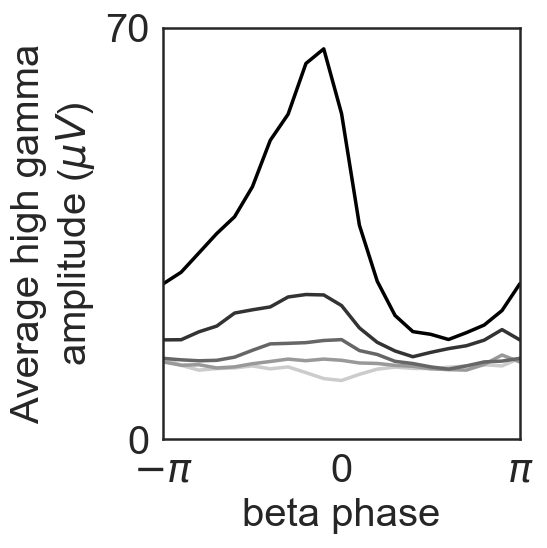

In [20]:
# Histogram with all sharpness ratios on one plot
plt.figure(figsize=(4,4))
for n in range(Nsharpg):
    plt.plot(np.hstack((phadist,np.pi)),np.hstack((hgadist_group[n],hgadist_group[n][0])),
             label=str(int(n*100/np.float(Nsharpg))) + ' - ' + str(int((n+1)*100/np.float(Nsharpg))) + '%',
             color=str(1-(n+1)/np.float(Nsharpg)))
plt.xlim((-np.pi,np.pi))
plt.xticks(np.arange(-np.pi,np.pi*1.1,np.pi),['$-\pi$',0,'$\pi$'],size=20)
plt.xlabel('beta phase',size=20)
plt.ylabel('Average high gamma\namplitude ($\mu V$)',size=20)
plt.yticks((0,70),size=20)
plt.ylim((0,70))
plt.tight_layout()

# E
### Spectrogram showing increased high gamma power at sharp extrema

In [21]:
# Calculate spectrograms
group = 'B'
subj = 0
x = ecog[group][subj]

f0s = np.arange(1,200)
w = 7

xwt = util.morletT(x,f0s,Fs, w=w)
xspect = np.log10(np.abs(xwt))

In [22]:
# Identify peak arrays of interest
xpks = pks[group][subj]
xpkssharp = pksharp[group][subj]

[  29.  198.  194.  267.  110.  253.]


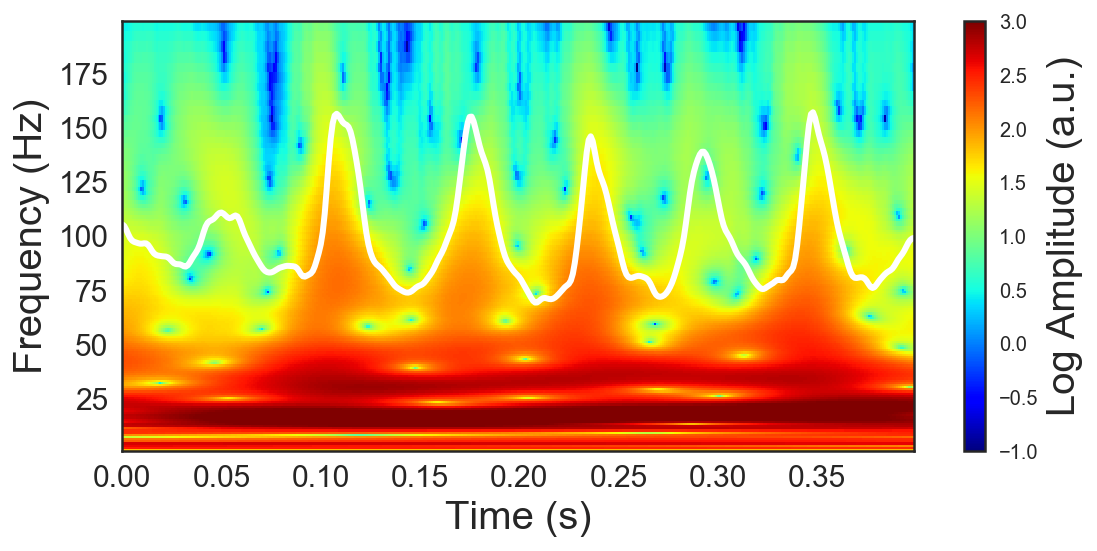

In [23]:
# Plot M1 spectrogram
trange = (7300,7700)
from matplotlib import cm
plt.figure(figsize=(8,4))
xspectplt = xspect[:,trange[0]:trange[1]]
cax = plt.pcolor(t[:trange[1]-trange[0]], f0s, xspectplt, cmap=cm.jet,
                 vmin=-1, vmax=3)
cbar = plt.colorbar(cax)
cbar.ax.set_ylabel('Log Amplitude (a.u.)', size=20)
plt.xlabel('Time (s)', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.plot(t[:trange[1]-trange[0]],x[trange[0]:trange[1]]*.1+100,'w',linewidth=3)

plt.tight_layout()

# print peak sharpness
print(np.round(xpkssharp[158:164]))

# F
### No oscillation when trigger to gamma peak

In [24]:
# Calculate time points of high frequency peaks in a signal
subj=0
m1 = ecog[group][subj]
f_higam = (50,200)

higamm1 = pac.firf(m1, f_higam, fs = Fs, rmvedge = False)
higampksm1 = np.array(sp.signal.find_peaks_cwt(higamm1, np.arange(1,10)))

In [25]:
# Only trigger on highest power hi gam pks
higampksm1 = higampksm1[higamm1[higampksm1]>=np.percentile(higamm1[higampksm1],90)]

In [26]:
# Define time interval for analysis
tplotmin = -.2
tplotmax = .2
splotmin = int(tplotmin*Fs)
splotmax = int(tplotmax*Fs)
tplot = np.arange(tplotmin,tplotmax,1/float(Fs))

# Remove hi gamma peaks close to boundary
higampksm1 = higampksm1[higampksm1>tplotmax*Fs]
higampksm1 = higampksm1[(len(m1)-higampksm1)>tplotmax*Fs]

In [27]:
# Calculate average signal triggered on high gamma peak
triggeredm1 = np.zeros(len(tplot))
P = len(higampksm1)
for p in range(P):
    newtimeseries = m1[higampksm1[p]+splotmin:higampksm1[p]+splotmax]
    triggeredm1 = triggeredm1 + newtimeseries/float(P)

([<matplotlib.axis.YTick at 0x115f35550>,
 <a list of 3 Text yticklabel objects>)

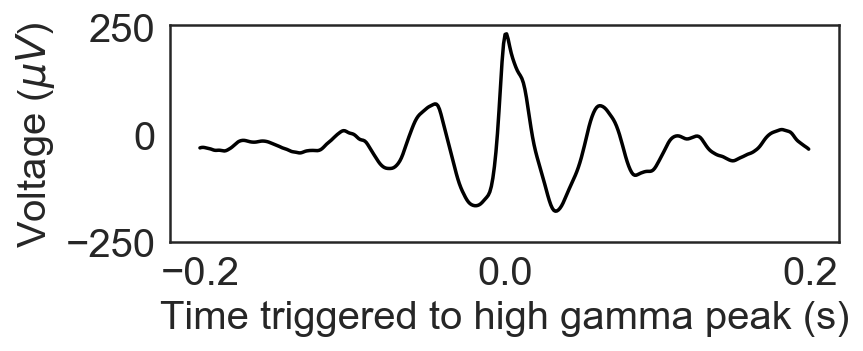

In [28]:
# Plot triggered time series
plt.figure(figsize=(6,2))
plt.plot(tplot,triggeredm1,'k')
plt.ylabel('Voltage ($\mu V$)',size=20)
plt.xlabel('Time triggered to high gamma peak (s)',size=20)
plt.xticks((-.2,0,.2),size=20)
plt.yticks((-250,0,250),size=20)